This notebook aims to predict blood pressure using bioimpedance measurements from graphene electronic tattoos.

For more detail and access to the data read this [article](https://physicsworld.com/a/graphene-tattoo-provides-cuffless-blood-pressure-monitoring/).

### **1. Data Exploration and Preprocessing**

### **1.1 Creating a combined dataset from the CSVs**

The goal of this section is to combine all of the CSVs into one pandas dataframe with the following schema:

***Subject, SetupType, Setup Trial, Time, Bioz, FinapresBP, FinapresPPG, PPG***

In [13]:
import pandas as pd
import os 
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

>##### **Lets start by reading the data related to one patient and setup.**

In [14]:
# The path to the setup results
path = "../../data/continuous-cuffless-monitoring-of-arterial-blood-pressure-via-graphene-bioimpedance-tattoos-1.0.0/subject1_day1/setup01_baseline"

csv_files_finapresBP = glob.glob(os.path.join(path, "*finapresBP.csv"))
csv_files_bioz = glob.glob(os.path.join(path, "*bioz.csv"))

# Combine both lists
csv_files = csv_files_finapresBP + csv_files_bioz

# A list to collect DataFrames
dfs = []

# Loop over the list of csv files 
for f in csv_files: 

    # To avoid issues caused by mixing Windows and Linux paths replace \\ with /
    f = f.replace("\\", "/")

    # Extract the trial, setup and subject info from the file path
    trial_string = f.split("/")[-1]
    setup_string = f.split("/")[-2]
    subject_string = f.split("/")[-3]

    # Process the strings into keys
    trial = int(trial_string.split('_')[1].replace('trial', ''))
    setup_type = setup_string.split('_')[1]  # Include the type of experiment done

    # Read the csv file and add the ids used to identify the experiment
    next_df = pd.read_csv(f)
    next_df['Subject'] = subject_string
    next_df['SetupType'] = setup_type
    next_df['Setup'] = setup_string
    next_df['Trial'] = trial  # Should be shared across files from the same trial

    dfs.append(next_df)

# Concatenate the dataframes into one
df = pd.concat(dfs, ignore_index=True)

df

,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
0,2.004923,98.48315,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
1,2.009923,98.14744,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
2,2.014923,97.80030,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
3,2.019923,97.44237,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
4,2.024923,97.07431,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
250334,87.596021,NaN,subject1_day1,baseline,setup01_baseline,1,-63.81312,-24.29105,4.84010,-8.15857
250335,87.596821,NaN,subject1_day1,baseline,setup01_baseline,1,-63.46248,-24.14836,5.12880,-8.18565
250336,87.597621,NaN,subject1_day1,baseline,setup01_baseline,1,-63.10261,-24.00241,5.41779,-8.21183
250337,87.598421,NaN,subject1_day1,baseline,setup01_baseline,1,-62.73376,-23.85328,5.70698,-8.23710


> ##### **An overview of the current dataset.**

In [15]:
# Set the Seaborn Style
sns.set_style("whitegrid")

In [16]:
display(df)
df.info()
df.describe()

,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
0,2.004923,98.48315,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
1,2.009923,98.14744,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
2,2.014923,97.80030,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
3,2.019923,97.44237,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
4,2.024923,97.07431,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
250334,87.596021,NaN,subject1_day1,baseline,setup01_baseline,1,-63.81312,-24.29105,4.84010,-8.15857
250335,87.596821,NaN,subject1_day1,baseline,setup01_baseline,1,-63.46248,-24.14836,5.12880,-8.18565
250336,87.597621,NaN,subject1_day1,baseline,setup01_baseline,1,-63.10261,-24.00241,5.41779,-8.21183
250337,87.598421,NaN,subject1_day1,baseline,setup01_baseline,1,-62.73376,-23.85328,5.70698,-8.23710


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250339 entries, 0 to 250338
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        250339 non-null  float64
 1   FinapresBP  33839 non-null   float64
 2   Subject     250339 non-null  object 
 3   SetupType   250339 non-null  object 
 4   Setup       250339 non-null  object 
 5   Trial       250339 non-null  int64  
 6   BioZ1       216500 non-null  float64
 7   BioZ2       216500 non-null  float64
 8   BioZ3       216500 non-null  float64
 9   BioZ4       216500 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 19.1+ MB


,time,FinapresBP,Trial,BioZ1,BioZ2,BioZ3,BioZ4
count,250339.000000,33839.000000,250339.000000,216500.000000,216500.000000,216500.000000,216500.000000
mean,44.299563,100.468637,1.499998,25.550801,9.075036,10.228314,3.341454
std,24.921961,14.259206,0.500001,42.981838,15.749782,15.668690,5.928609
min,1.000021,70.307840,1.000000,-84.635750,-31.683900,-40.261580,-15.341980
25%,22.718821,88.941565,1.000000,-3.573203,-1.582795,-0.110363,-0.917353
50%,44.299923,98.811970,1.000000,39.825125,14.179090,11.960885,4.429660
75%,65.880421,111.115920,2.000000,60.602902,21.819870,20.173572,7.746480
max,87.599221,136.984660,2.000000,94.314210,38.766850,62.628790,18.657800


Show the correlation matrix of each of the variables.

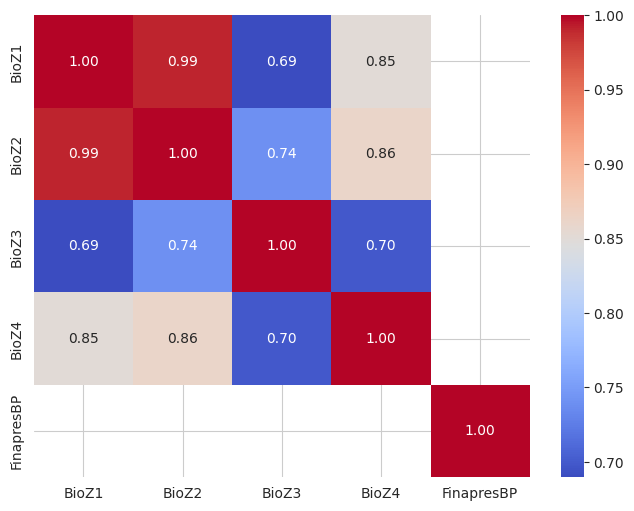

In [17]:
correlation_matrix = df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

There is no correlation between the BioZ measurements and FinapresBP because the time measurements do share overlapping timestamps (whenever one has values the other has NaNs)

In [18]:
display(df[df['FinapresBP'].notna()])
display(df[df['BioZ1'].notna()])

,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
0,2.004923,98.48315,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
1,2.009923,98.14744,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
2,2.014923,97.80030,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
3,2.019923,97.44237,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
4,2.024923,97.07431,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
33834,86.575961,88.07976,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN
33835,86.580961,87.74439,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN
33836,86.585961,87.43317,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN
33837,86.590961,87.15423,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN


,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
33839,1.000021,NaN,subject1_day1,baseline,setup01_baseline,2,54.75861,19.28289,28.37978,9.61708
33840,1.000821,NaN,subject1_day1,baseline,setup01_baseline,2,54.88802,19.34258,28.47379,9.61511
33841,1.001621,NaN,subject1_day1,baseline,setup01_baseline,2,55.01903,19.40285,28.56771,9.61298
33842,1.002421,NaN,subject1_day1,baseline,setup01_baseline,2,55.15161,19.46372,28.66151,9.61069
33843,1.003221,NaN,subject1_day1,baseline,setup01_baseline,2,55.28571,19.52515,28.75516,9.60825
...,...,...,...,...,...,...,...,...,...,...
250334,87.596021,NaN,subject1_day1,baseline,setup01_baseline,1,-63.81312,-24.29105,4.84010,-8.15857
250335,87.596821,NaN,subject1_day1,baseline,setup01_baseline,1,-63.46248,-24.14836,5.12880,-8.18565
250336,87.597621,NaN,subject1_day1,baseline,setup01_baseline,1,-63.10261,-24.00241,5.41779,-8.21183
250337,87.598421,NaN,subject1_day1,baseline,setup01_baseline,1,-62.73376,-23.85328,5.70698,-8.23710


>##### **I'll visualise one trial to get an understanding of the data.**

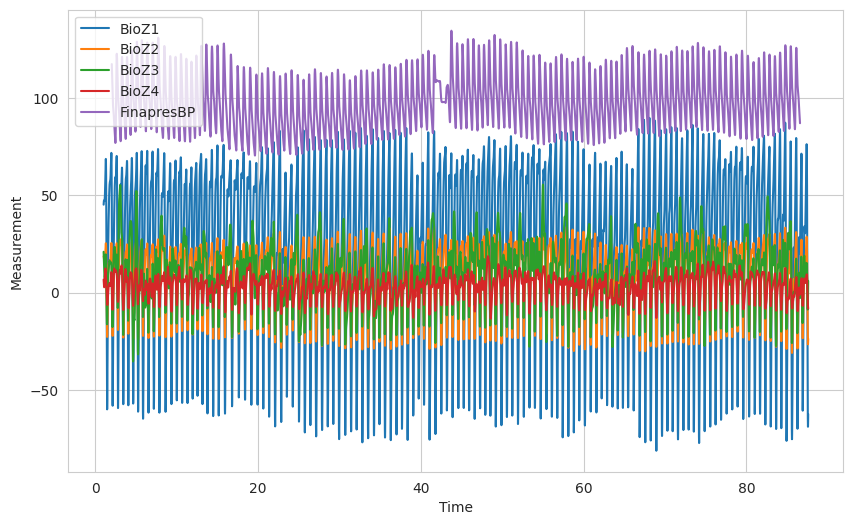

In [19]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

trial1_df = df[df['Trial'] == 1]
# Create the plot
plt.figure(figsize=(10, 6))

for column in columns_to_plot:
    sns.lineplot(data=trial1_df, x='time', y=column, label=column)

plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()

plt.show()

It's a bit cluttered. For more detail I'll limit it to a 5 second stretch

In [20]:
def plot_measurements(df, start_time, end_time):

    # Filter the DataFrame by time
    plot_df = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

    # Create the plot
    plt.figure(figsize=(10, 6))

    for column in columns_to_plot:
        sns.lineplot(data=plot_df, x='time', y=column, label=column)

    plt.xlabel('Time')
    plt.ylabel('Measurement')
    plt.legend()
    plt.show()

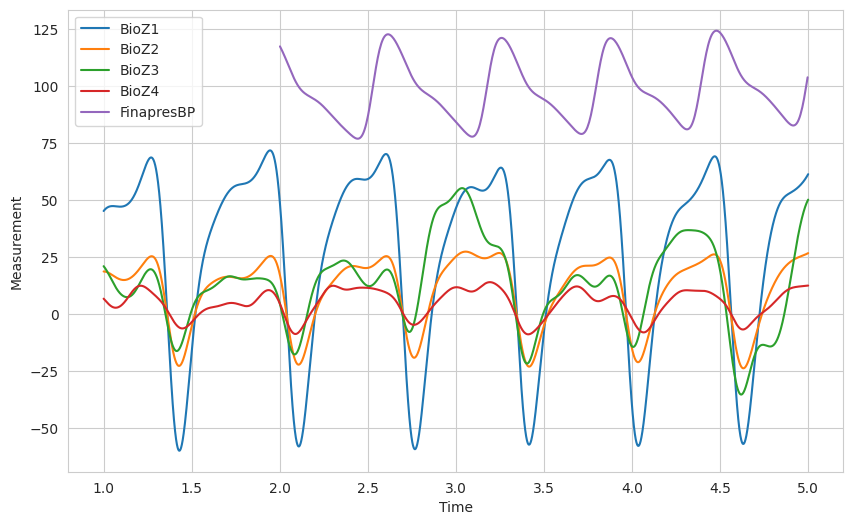

In [21]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

plot_measurements(trial1_df, 0, 5)

We can see that the *FinapresBP* measurements start after the *BioZ* measurements.

Lets plot each Measurement directly against Blood Pressure.

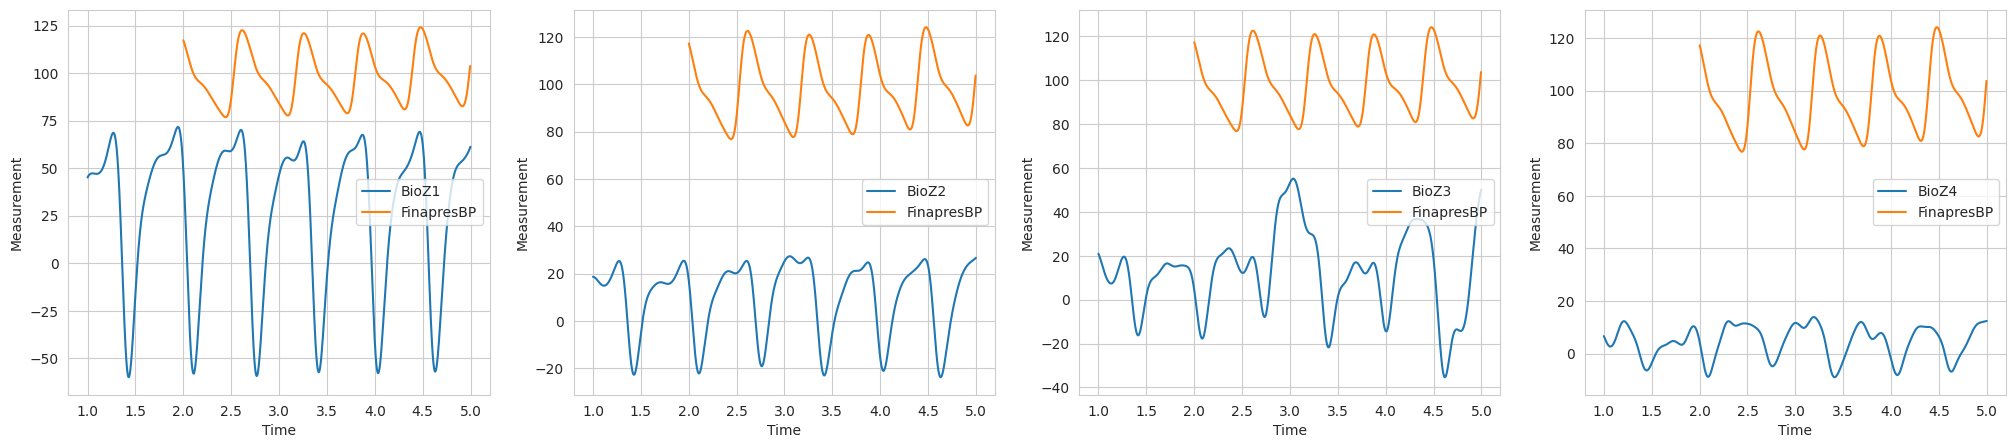

In [22]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(25, 5))

plot_df = trial1_df[(trial1_df['time'] >= 0) & (trial1_df['time'] <= 5)]

for ax, column in zip(axs, columns_to_plot):
    sns.lineplot(data=plot_df, x='time', y=column, label=column, ax=ax)
    sns.lineplot(data=plot_df, x='time', y='FinapresBP', label='FinapresBP', ax=ax)
    ax.set_xlabel('Time')
    ax.set_ylabel('Measurement')
    ax.legend(loc='center right')

plt.show()

The two types of measurement also seem to be slightly out of phase, due to the sensor's different position on the arm.

### **1.2 Constuct a Common Time Axis**

I am going to repeat the approach from the starter notebook to create a shared time axis.

This will be shown using the first trial.

In [23]:
trial1_df = df[df['Trial']==1]
bioz_df = trial1_df.drop(columns='FinapresBP').dropna()
bp_df = trial1_df.drop(columns=['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']).dropna()
display(bioz_df)
display(bp_df)

,time,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
142089,1.000021,subject1_day1,baseline,setup01_baseline,1,45.11402,18.60437,20.92109,6.67912
142090,1.000821,subject1_day1,baseline,setup01_baseline,1,45.19330,18.60317,20.84464,6.61070
142091,1.001621,subject1_day1,baseline,setup01_baseline,1,45.27085,18.60096,20.76674,6.54201
142092,1.002421,subject1_day1,baseline,setup01_baseline,1,45.34667,18.59775,20.68740,6.47308
142093,1.003221,subject1_day1,baseline,setup01_baseline,1,45.42077,18.59353,20.60664,6.40395
...,...,...,...,...,...,...,...,...,...
250334,87.596021,subject1_day1,baseline,setup01_baseline,1,-63.81312,-24.29105,4.84010,-8.15857
250335,87.596821,subject1_day1,baseline,setup01_baseline,1,-63.46248,-24.14836,5.12880,-8.18565
250336,87.597621,subject1_day1,baseline,setup01_baseline,1,-63.10261,-24.00241,5.41779,-8.21183
250337,87.598421,subject1_day1,baseline,setup01_baseline,1,-62.73376,-23.85328,5.70698,-8.23710


,time,FinapresBP,Subject,SetupType,Setup,Trial
16919,2.000961,117.25990,subject1_day1,baseline,setup01_baseline,1
16920,2.005961,116.50575,subject1_day1,baseline,setup01_baseline,1
16921,2.010961,115.71514,subject1_day1,baseline,setup01_baseline,1
16922,2.015961,114.89302,subject1_day1,baseline,setup01_baseline,1
16923,2.020961,114.04378,subject1_day1,baseline,setup01_baseline,1
...,...,...,...,...,...,...
33834,86.575961,88.07976,subject1_day1,baseline,setup01_baseline,1
33835,86.580961,87.74439,subject1_day1,baseline,setup01_baseline,1
33836,86.585961,87.43317,subject1_day1,baseline,setup01_baseline,1
33837,86.590961,87.15423,subject1_day1,baseline,setup01_baseline,1


> ##### **Interpolate the data onto a common time axis.**

In [ ]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [32]:
start_time = max(min(bioz_df['time']), min(bp_df['time']))
end_time = min(max(bioz_df['time']), max(bp_df['time']))
common_time = np.linspace(start_time, end_time, num=len(bp_df))  # Instead of 1000 I will match the sampling rate of the Finapres data

finapres_interpolator = interp1d(bp_df['time'], bp_df['FinapresBP'], bounds_error=False, fill_value="extrapolate")
bioz1_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ1'], bounds_error=False, fill_value="extrapolate")
bioz2_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ2'], bounds_error=False, fill_value="extrapolate")
bioz3_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ3'], bounds_error=False, fill_value="extrapolate")
bioz4_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ4'], bounds_error=False, fill_value="extrapolate")

finapres_common = finapres_interpolator(common_time)
bioz1_common = bioz1_interpolator(common_time)
bioz2_common = bioz2_interpolator(common_time)
bioz3_common = bioz3_interpolator(common_time)
bioz4_common = bioz3_interpolator(common_time)

Create a dataframe with the new time axis.

In [33]:
bp_df['BioZ1'] = bioz1_common
bp_df['BioZ2'] = bioz2_common
bp_df['BioZ3'] = bioz3_common
bp_df['BioZ4'] = bioz4_common

bp_df

,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
16919,2.000961,117.25990,subject1_day1,baseline,setup01_baseline,1,48.332439,16.943260,4.337878,4.337878
16920,2.005961,116.50575,subject1_day1,baseline,setup01_baseline,1,43.384880,15.087782,2.756093,2.756093
16921,2.010961,115.71514,subject1_day1,baseline,setup01_baseline,1,37.969078,13.056467,1.085794,1.085794
16922,2.015961,114.89302,subject1_day1,baseline,setup01_baseline,1,32.123190,10.864834,-0.655107,-0.655107
16923,2.020961,114.04378,subject1_day1,baseline,setup01_baseline,1,25.896649,8.532647,-2.445484,-2.445484
...,...,...,...,...,...,...,...,...,...,...
33834,86.575961,88.07976,subject1_day1,baseline,setup01_baseline,1,20.277790,4.039298,-2.759994,-2.759994
33835,86.580961,87.74439,subject1_day1,baseline,setup01_baseline,1,20.673994,4.207431,-2.845577,-2.845577
33836,86.585961,87.43317,subject1_day1,baseline,setup01_baseline,1,21.228864,4.447118,-2.823403,-2.823403
33837,86.590961,87.15423,subject1_day1,baseline,setup01_baseline,1,21.935641,4.756011,-2.693616,-2.693616


Now that they share an axis the correlation between the ***BioZ*** and ***FinapresBP*** measurements can be examined.

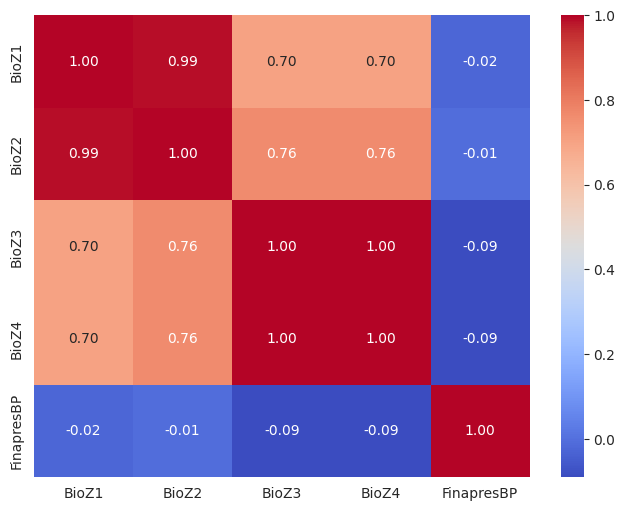

In [34]:
correlation_matrix = bp_df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

The correlation is quite low, this is most likely because the two measurements are still out of phase.

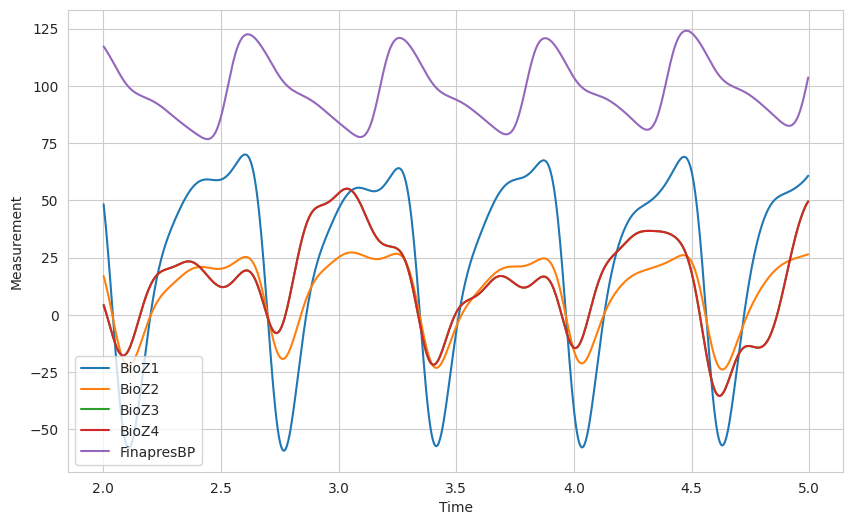

In [47]:
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']
plot_measurements(bp_df, 0, 5)

Lets try a regression.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [52]:
features = bp_df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']].values
target = bp_df['FinapresBP'].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1234)

# Step 5: Initialize, train, and evaluate the regression model
model = RandomForestRegressor(n_estimators=100, random_state=1234)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 6.8221642556737585
Root Mean Squared Error: 9.6551001923908
R^2 Score: 0.515688609063442


I'll try to improve this by making them in-phase.

> ##### **Use Cross-correlation to align the series.**

As different, subjects might have different gaps between the measurements, I'll use cross-correlation to align the different measurements instead of a hard-coded shift.

In [85]:
from scipy.signal import correlate

In [ ]:
series1 = bp_df['FinapresBP']
series2 = -1 * bp_df['BioZ1']  # Invert the BioZ measurement to correctly measure the point of highest correlation

# Compute cross-correlation on the normalised series
series = (a - np.mean(a)) / (np.std(a) * len(a))
b = (b - np.mean(b)) / (np.std(b))
lags = np.arange(-len(series1) + 1, len(series1))
cross_correlation = correlate(series1 - series1.mean(), series2 - series2.mean(), mode='full')
cross_correlation /= np.sqrt(np.dot(series1 - series1.mean(), series1 - series1.mean()) * np.dot(series2 - series2.mean(), series2 - series2.mean()))

# Find the lag with the maximum correlation
lag_max = lags[cross_correlation.argmax()]

# Plot cross-correlation
plt.figure(figsize=(10, 5))
plt.plot(lags, cc)
plt.title('Cross-correlation')
plt.xlabel('Lag')
plt.ylabel('Correlation coefficient')
plt.axvline(x=lag_max, color='r', linestyle='--')
plt.show()

print(f"The maximum correlation is at lag {lag_max}.")

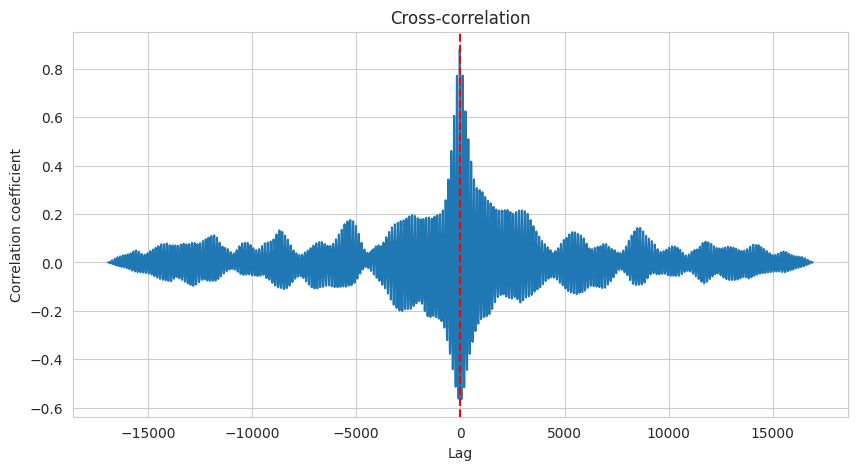

The maximum correlation is at lag -30.


In [87]:
series1 = bp_df['FinapresBP']
series2 = -1 * bp_df['BioZ1']  # Invert the BioZ measurement to correctly measure the point of highest correlation

# Compute cross-correlation on the normalised series
lags = np.arange(-len(series1) + 1, len(series1))
cross_correlation = correlate(series1 - series1.mean(), series2 - series2.mean(), mode='full')
cross_correlation /= np.sqrt(np.dot(series1 - series1.mean(), series1 - series1.mean()) * np.dot(series2 - series2.mean(), series2 - series2.mean()))

# Find the lag with the maximum correlation
lag_max = lags[cross_correlation.argmax()]

# Plot cross-correlation
plt.figure(figsize=(10, 5))
plt.plot(lags, cc)
plt.title('Cross-correlation')
plt.xlabel('Lag')
plt.ylabel('Correlation coefficient')
plt.axvline(x=lag_max, color='r', linestyle='--')
plt.show()

print(f"The maximum correlation is at lag {lag_max}.")

>##### **Now I'll repeat this with all of the CSVs**

In [ ]:
# Create a list for the dataframes again
dfs = []

# Set this to the to the root folder of the data
path = "../../data/continuous-cuffless-monitoring-of-arterial-blood-pressure-via-graphene-bioimpedance-tattoos-1.0.0"

# Get all of the subject folders
subject_folders = glob.glob(os.path.join(path, "*" + os.sep))  # os.sep ensures that only directories are matched

# Iterate over each subject folder abd examine each setup folder
for subject_folder in subject_folders:
    setup_folders = glob.glob(os.path.join(subject_folder, "*" + os.sep))

    # Iterate over each setup folder adding the CSVs within
    for setup_folder in setup_folders:
        csv_files_finapresBP = glob.glob(os.path.join(path, "*finapresBP.csv"))
        csv_files_bioz = glob.glob(os.path.join(path, "*bioz.csv"))

        # Combine both lists
        csv_files = csv_files_finapresBP + csv_files_bioz

        # Loop over the list of csv files 
        for f in csv_files: 

            # To avoid issues caused by mixing Windows and Linux paths replace \\ with /
            f = f.replace("\\", "/")

            # Extract the trial, setup and subject info from the file path
            trial_string = f.split("/")[-1]
            setup_string = f.split("/")[-2]
            subject_string = f.split("/")[-3]

            # Process the strings into keys
            trial = int(trial_string.split('_')[1].replace('trial', ''))
            setup_type = setup_string.split('_')[1]  # Include the type of experiment done

            # Read the csv file and add the ids used to identify the experiment
            next_df = pd.read_csv(f)
            next_df['Subject'] = subject_string
            next_df['SetupType'] = setup_type
            next_df['Setup'] = setup_string
            next_df['Trial'] = trial  # Should be shared across files from the same trial

            dfs.append(next_df)

df = pd.concat(dfs, ignore_index=True)

ValueError: No objects to concatenate

Get each metric on 1 row again.

In [ ]:
#df = df.groupby(['Subject', 'SetupType', 'Setup', 'Trial', 'time']).agg('mean').reset_index()

An overview of the dataset.

In [ ]:
display(df)
df.info()
df.describe()

,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4,PPG,FinapresPPG
0,2.001273,61.51059,subject4_day1,hgcp,setup03_hgcp,12,NaN,NaN,NaN,NaN,NaN,NaN
1,2.006273,61.43445,subject4_day1,hgcp,setup03_hgcp,12,NaN,NaN,NaN,NaN,NaN,NaN
2,2.011273,61.33912,subject4_day1,hgcp,setup03_hgcp,12,NaN,NaN,NaN,NaN,NaN,NaN
3,2.016273,61.22310,subject4_day1,hgcp,setup03_hgcp,12,NaN,NaN,NaN,NaN,NaN,NaN
4,2.021273,61.08539,subject4_day1,hgcp,setup03_hgcp,12,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
63191121,86.576755,139.61385,subject1_day1,hgcp,setup07_hgcp,29,NaN,NaN,NaN,NaN,NaN,NaN
63191122,86.581755,138.12162,subject1_day1,hgcp,setup07_hgcp,29,NaN,NaN,NaN,NaN,NaN,NaN
63191123,86.586755,136.61745,subject1_day1,hgcp,setup07_hgcp,29,NaN,NaN,NaN,NaN,NaN,NaN
63191124,86.591755,135.11783,subject1_day1,hgcp,setup07_hgcp,29,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63191126 entries, 0 to 63191125
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   time         float64
 1   FinapresBP   float64
 2   Subject      object 
 3   SetupType    object 
 4   Setup        object 
 5   Trial        int64  
 6   BioZ1        float64
 7   BioZ2        float64
 8   BioZ3        float64
 9   BioZ4        float64
 10  PPG          float64
 11  FinapresPPG  float64
dtypes: float64(8), int64(1), object(3)
memory usage: 5.6+ GB


: 

We should double check that the data aligns with the folders and the descriptions in the README. 

In [ ]:
print(df['Subject'].unique(), "\n")
print(df['SetupType'].unique(), "\n")

Show the correlation matrix of each of the variables.

In [ ]:
correlation_matrix = df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresPPG', 'PPG', 'FinapresBP']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()